In [1]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

In [3]:
#Standard modules
import os
import time
import random

import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

#Custom modules
import helpers as hlp
import models as mdl

# Check avaibale device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(DEVICE))

Device: cuda


### Reproductability

In [4]:
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Parameters

In [10]:
#Dataset
DATASET = "FMNIST" 
REDUCED = 0.2

#Collaborative learning
N_CLIENTS = 4
SIZES = None # None for uniform sizes or array of length N_CLIENTS using all the data
ALPHA = "uniform" #'uniform', 'disjoint' or postive.

#Learning
BATCH_SIZE = 64
ROUNDS = 100
EPOCHS_PER_ROUND = 1
LR=1e-2
LAMBDA = 1
CRITERION = nn.CrossEntropyLoss()
CRITERION_DISC = hlp.DiscLoss()
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

#Directories
DATE = datetime.now()
EXPORT_DIR = "./saves/Experiments/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
#os.makedirs(EXPORT_DIR, exist_ok=True)

### Data loadiing

** Using FMNIST **
Load train data...
Load validation data...
Dataset sizes:
	- Train: (12000, 1, 28, 28)
	- Validation (2000, 1, 28, 28)


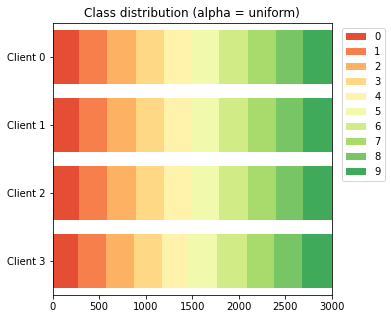

In [11]:
# Load dataset
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET,
                                                                       reduced=REDUCED,
                                                                       device=DEVICE)

#Create custom torch datasets
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

#Split dataset
train_ds_list, val_ds_list = hlp.split_dataset(N_CLIENTS, train_ds, val_ds, ALPHA, SIZES)

#Create dataloader
train_dl_list = hlp.ds_to_dl(train_ds_list, batch_size=BATCH_SIZE)
val_dl_list = hlp.ds_to_dl(val_ds_list)


#Visualize partition
hlp.visualize_class_dist(train_ds_list, meta["n_class"], title="Class distribution (alpha = {})".format(ALPHA),savepath=None)

### Traditional (spearated) learning

In [ ]:
# Model initialization
client_models = [mdl.get_model(DATASET).to(DEVICE) for _ in range(N_CLIENTS)]
    
# Performance tracker
perf_trackers = [hlp.PerfTracker(client_models[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i]}, 
                                 CRITERION, meta["n_class"], ID="Client {}".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers = [torch.optim.SGD(m.parameters(), lr=LR) for m in client_models]

# Feature tracker
feat_tracker = hlp.FeatureTracker(client_models, train_ds_list, meta)

#Each client updates its model independently on its own dataset
for r in range(ROUNDS):
    t0 = time.time()
    
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        model = client_models[client_id]
        model.train()
        optimizer = optimizers[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, target in train_dl_list[client_id]:
                optimizer.zero_grad()
                logits = model(inputs)
                loss = CRITERION(logits, target)
                loss.backward()
                optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf_trackers_kd[client_id].new_eval(index=r)      
        
    # Compute representations
    feat_tracker.new_round()
    
    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ")   

# Plot training history
hlp.plot_global_training_history(perf_trackers, metric="accuracy")
hlp.plot_global_training_history(perf_trackers, metric="loss")

Round 33 done. (1.0s)          

### Learning with private KD

Round 100 done. (1.1s)          

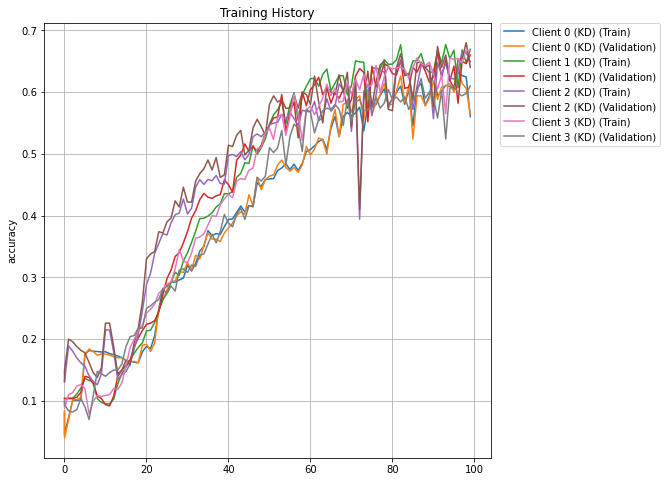

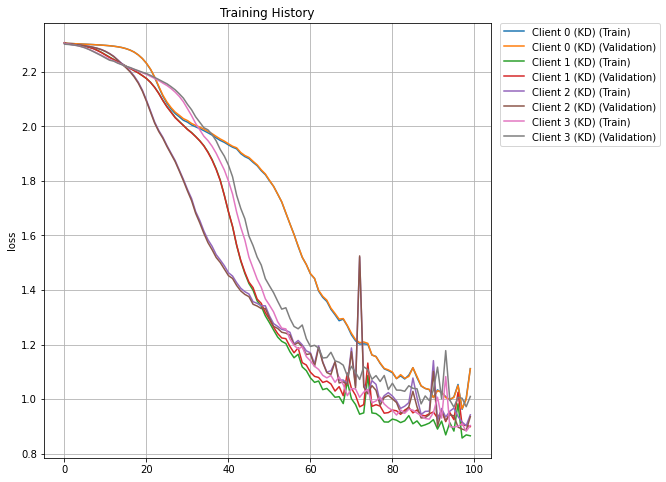

In [47]:
# Model initialization
client_models_kd = [mdl.get_model(DATASET).to(DEVICE) for _ in range(N_CLIENTS)]
meta["feat_dim"] = client_models_kd[0].classifier.in_features

# Performance tracker
perf_trackers_kd = [hlp.PerfTracker(client_models_kd[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i]}, 
                                    CRITERION, meta["n_class"], ID="Client {} (KD)".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers_kd = [torch.optim.SGD(m.parameters(), lr=LR) for m in client_models_kd]

# Feature tracker
feat_tracker_kd = hlp.FeatureTracker(client_models_kd, train_ds_list, meta)

#Each client updates its model locally on its own dataset (Standard)
for r in range(ROUNDS):
    t0 = time.time()
    
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        model = client_models_kd[client_id]
        model.train()
        optimizer = optimizers_kd[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, targets in train_dl_list[client_id]:
                # Reset gradient
                optimizer.zero_grad()
                
                # Local representation
                features = model.features(inputs)
                logits = model.classifier(features)
                
                # Compute estimated probabilities
                prob = F.softmax(logits, dim=1)
                logits_global = model.classifier(feat_tracker_kd.get_global_features().to(DEVICE))
                prob_global = F.softmax(logits_global, dim=1)
                
                # Optimization step
                if LAMBDA:
                    loss = CRITERION(logits, targets) + LAMBDA*CRITERION_DISC(prob, prob_global, targets, torch.arange(10).to(DEVICE))
                else:
                    loss = CRITERION(logits, targets)
                loss.backward()
                optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf_trackers_kd[client_id].new_eval(index=r)      
        
    # Compute representations
    feat_tracker_kd.new_round()
    
    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ")  

# Plot training history
hlp.plot_global_training_history(perf_trackers_kd, metric="accuracy")
hlp.plot_global_training_history(perf_trackers_kd, metric="loss")

### Convert to executable

In [14]:
# Convert to executable (without the Magic cells)
#!jupyter nbconvert \
#    --TagRemovePreprocessor.enabled=True \
#    --TagRemovePreprocessor.remove_cell_tags 'Magic' \
#    --TemplateExporter.exclude_markdown=True \
#    --to python "BlindLearning.ipynb"


[NbConvertApp] Converting notebook BlindLearning.ipynb to python
[NbConvertApp] Writing 10602 bytes to BlindLearning.py


In [16]:
from sklearn.manifold import TSNE
user = 0
embedder =  TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)

feat_emb = embedder.fit_transform(torch.cat((features_history[-1][user], features_global[-1])).numpy())

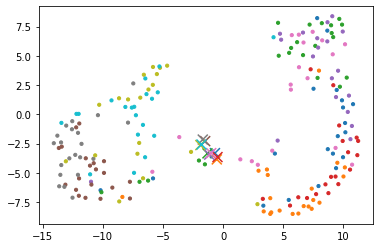

In [17]:
plt.scatter(feat_emb[:-10,0], feat_emb[:-10,1], c=train_ds_list[user].targets, s=10, cmap="tab10")
plt.scatter(feat_emb[-10:,0], feat_emb[-10:,1], marker="x", c=range(10), s=100, cmap="tab10")

4


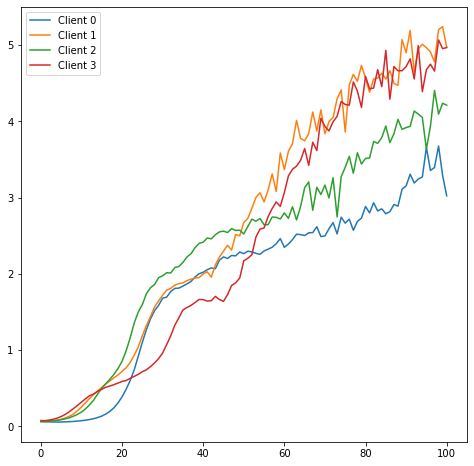

In [48]:
feat_tracker_kd.plot_class_distance(0, 1)

In [42]:
[[(feat[0] - feat[1]) for feat in feat_tracker_kd.average_features[i]] for i in range(feat_tracker_kd.n_clients)]

[[tensor([ 5.0396e-01,  1.1430e-01,  6.4023e-02, -2.8942e-01, -9.6787e-01,
           5.2139e-01,  6.2290e-01, -6.7403e-03, -2.2384e-03,  2.8705e-01,
           8.7130e-01,  7.5344e-01,  4.0530e-01,  1.2247e-01, -8.4071e-03,
           4.4265e-01, -8.3632e-01,  2.8023e-01,  7.6836e-02, -8.6196e-01,
          -9.6427e-01,  1.5838e-03,  9.9763e-03,  7.7747e-01, -1.0422e+00,
          -3.6289e-02,  7.7765e-02, -8.7745e-02,  1.0183e+00, -5.8219e-01,
          -1.2138e+00, -7.7307e-01,  7.2987e-01,  1.5941e-01,  9.4751e-01,
           9.8541e-02, -2.9483e-01, -3.6762e-01, -1.0325e-01,  9.4259e-01,
           7.6784e-02, -5.1978e-01,  1.2453e-01, -1.9004e-01, -2.7747e-02,
           2.6351e-02,  4.5145e-04, -1.3709e-01, -1.4865e-03,  1.5031e-03,
          -3.6300e-02, -3.5641e-01, -8.6794e-01,  8.2560e-02, -4.6231e-01,
           1.4969e-01,  9.1041e-02,  1.2183e-01, -1.6836e-01, -1.3204e-01,
          -2.3211e-02,  1.0232e-01,  7.2308e-01,  5.8045e-02,  5.0586e-01,
          -5.4531e-01, -2

In [43]:
feat_tracker_kd.average_features[0]

[tensor([[ 0.0069, -0.8285, -0.9251, -0.4069, -0.2043, -0.3192, -0.1745,  0.9931,
           0.9977,  0.3441,  0.6439,  0.5692, -0.5315,  0.6399,  0.9911, -0.3005,
          -0.0962, -0.1626, -0.9003, -0.4088, -0.3519, -0.9984, -0.9899,  0.0027,
          -0.6060,  0.9591,  0.0502,  0.9046,  0.7088,  0.0726, -0.5433, -0.3280,
           0.3900, -0.8260,  0.1338, -0.8536,  0.3721,  0.5659,  0.8835,  0.3576,
          -0.9197,  0.3406, -0.8235,  0.7629,  0.9227, -0.9723, -0.9995,  0.8326,
           0.9984, -0.9984,  0.9584,  0.5775, -0.4168, -0.8496,  0.1466, -0.8360,
          -0.9026,  0.7230,  0.8171,  0.8391,  0.7514, -0.8382,  0.1064, -0.9238,
           0.5692, -0.0306,  0.6274, -0.7227, -0.6495, -0.0755,  0.0435, -0.9944,
           0.0995,  0.7694,  0.9827,  0.9547,  0.9607,  0.2527, -0.1485,  0.5195,
           0.7217,  0.5741, -0.9902, -0.8228],
         [-0.4970, -0.9428, -0.9891, -0.1175,  0.7636, -0.8406, -0.7974,  0.9998,
           0.9999,  0.0571, -0.2274, -0.1842, -0.93